This notebook contains a demonstration of Project code for class presentation.  The following components are included:

(1) Dataset visualization  
(2) Recommendation System using Agglomerative Clustering and Affinity Propagation

In [1]:
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn import metrics


%matplotlib inline

## Visualizations

**TF-IDF Vectorization**

In [2]:
cats = ['art', 'gaming', 'music', 'politics_news', 'reading', 'science', 'sports', 'tech']
stem = 'lemma'

In [3]:
documents = []

for cat in cats:
    os.chdir(fr'..\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'..\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [5]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()  # default n_components=2 for plotting

X = svd.fit_transform(X)

In [6]:
def get_label(i, colors, documents):
    """
    The get_label function helps plot one label per category.  Probably could find an easier way to do it, but this way
    worked for me when I was starting the project.
    """
    if colors[documents[i][1]][1] == 0:
        colors[documents[i][1]][1] += 1
        return documents[i][1]
    else:
        return ""

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

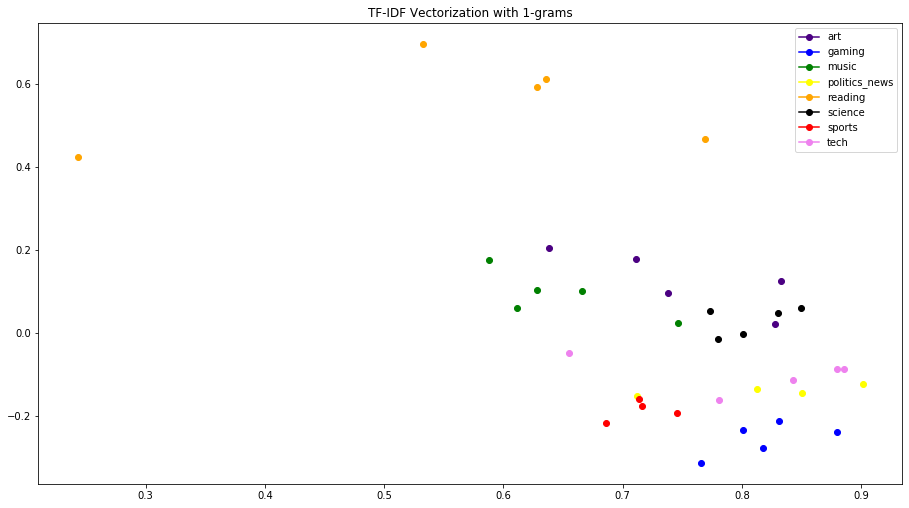

In [7]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

**Document Embeddings**

In [8]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [9]:
cats.remove('reading')

In [10]:
documents = []

for cat in cats:
    os.chdir(fr'..\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'..\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [11]:
os.chdir(r'..\Data')

model = Doc2Vec.load('subs.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)
labels = np.array(documents[:, 2], dtype=int)

Text(0.5, 1.0, 'Document Embeddings for Subreddits')

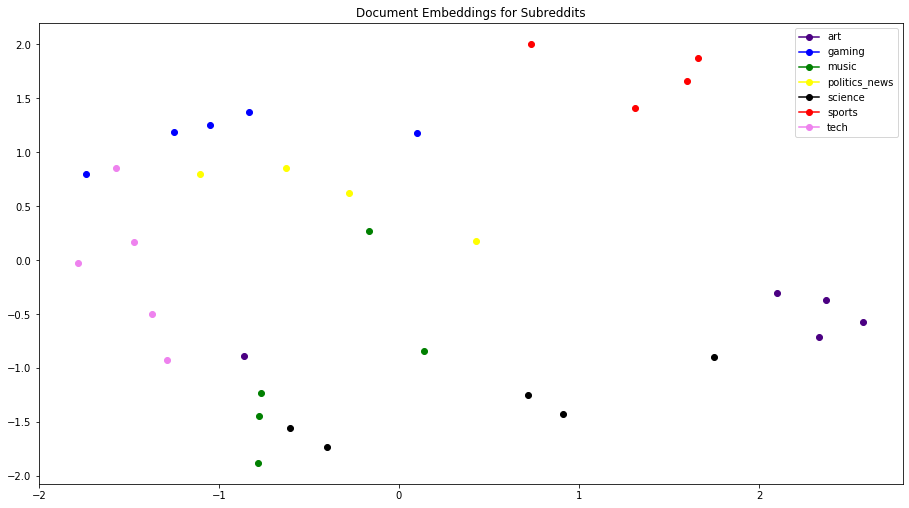

In [12]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Document Embeddings for Subreddits')

## Application

**Create Models**

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation

In [ ]:
docs = list(documents[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [14]:
agg = AgglomerativeClustering(n_clusters=11, linkage='ward')
agg.fit(doc_scaled)

af = AffinityPropagation()
af.fit(doc_scaled)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

**View Model Evaluations**

In [27]:
print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=agg.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, agg.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, agg.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, agg.labels_))

Silhouette score: 0.410948246717453
Homogeneity: 0.809
Completeness: 0.672
V-measure: 0.734


In [28]:
print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=af.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))

Silhouette score: 0.3762623965740204
Homogeneity: 0.763
Completeness: 0.841
V-measure: 0.800


**Grab a random subreddit**

In [29]:
doc_id = random.randint(0, len(tagged_data) - 1)
inferred_vector = model.infer_vector(tagged_data[doc_id][0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

indexes = np.array(sims[1:11], dtype=int)[:, 0]

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: worldnews
Sample category: politics_news


**Agglomerative Clustering Recommendations**

In [30]:
cluster = agg.labels_[doc_id]
same_cluster_index = np.where(agg.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

gaming
news
technology


**Affinity Propagation Recommendations**

In [31]:
cluster = af.labels_[doc_id]
same_cluster_index = np.where(af.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

news
PoliticalHumor
politics
